In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rc('figure', dpi=100, figsize=(10, 5))
plt.rc('font', size=12)

C:\Users\costi\AppData\Local\Temp\ipykernel_24124\1271768541.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


## The Kolmogorov-Smirnov test statistic

### Recap: permutation tests

- Permutation tests help decide whether **two samples came from the same distribution**.
- In a permutation test, we simulate data under the null by **shuffling** either group labels or numerical features.
    - In effect, this **randomly assigns individuals to groups**.
- If the two distributions are **quantitative (numerical)**, we use as our test statistic the **difference in group means or medians**.
- If the two distributions are **qualitative (categorical)**, we use as our test statistic the **total variation distance (TVD)**.

### Difference in means

The difference in means works well in some cases. Let's look at one such case.

Below, we artificially generate two numerical datasets.

In [2]:
np.random.seed(42) # So that we get the same results each time (for lecture)

N = 1000 # number of samples for each distribution

# Distribution 'A'
distr1 = pd.Series(np.random.normal(0, 1, size=N//2))

# Distribution 'B'
distr2 = pd.Series(np.random.normal(3, 1, size=N//2))

data = pd.concat([distr1, distr2], axis=1, keys=['A', 'B']).unstack().reset_index().drop('level_1', axis=1)
data = data.rename(columns={'level_0': 'group', 0: 'data'})

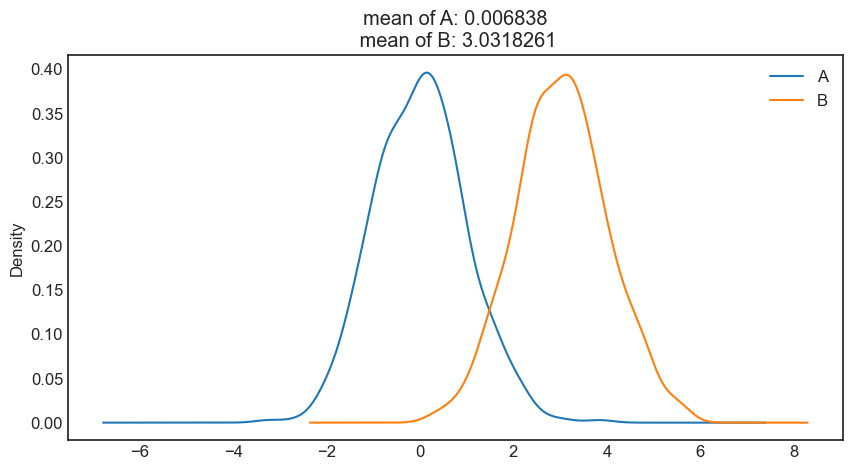

In [3]:
meanA, meanB = data.groupby('group')['data'].mean().round(7).tolist()
title = f'mean of A: {meanA}\n mean of B: {meanB}'

data.groupby('group')['data'].plot(kind='kde', legend=True, title=title);

### Discussion Question

- So far, we have used the difference in means as our test statistic in quantitative permutation tests.
- We've concluded that **two distributions were likely different if their means were different**.
- Can you think of two **different** distributions that have the same mean? 🤔

### Different distributions with the same mean

Let's generate two distributions that look very different but have the same mean.

In [4]:
np.random.seed(42) # So that we get the same results each time (for lecture)

N = 1000 # number of samples for each distribution

# Distribution 'A'
a = pd.Series(np.random.normal(0, 1, size=N//2))
b = pd.Series(np.random.normal(4, 1, size=N//2))
distr1 = pd.concat([a,b], ignore_index=True)

# Distribution 'B'
distr2 = pd.Series(np.random.normal(distr1.mean(), distr1.std(), size=N))

data = pd.concat([distr1, distr2], axis=1, keys=['A', 'B']).unstack().reset_index().drop('level_1', axis=1)
data = data.rename(columns={'level_0': 'group', 0: 'data'})


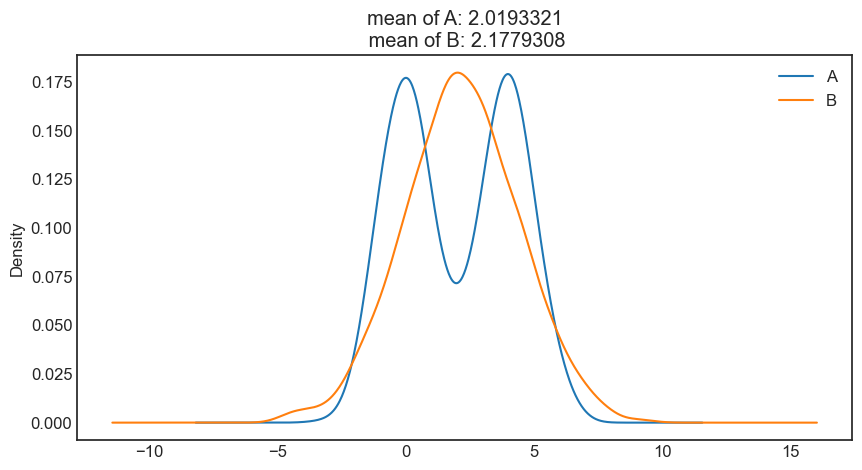

In [5]:
meanA, meanB = data.groupby('group')['data'].mean().round(7).tolist()
title = f'mean of A: {meanA}\n mean of B: {meanB}'

data.groupby('group')['data'].plot(kind='kde', legend=True, title=title);

In this case, if we use the difference in means as our test statistic in a permutation test, we will fail to reject the null that the two distributions are different.

In [6]:
n_repetitions = 500
shuffled = data.copy()

diff_means = []
for _ in range(n_repetitions):
    
    # Shuffling the data and assigning it back to the DataFrame
    shuffled['data'] = np.random.permutation(shuffled['data'])
    
    # Computing and storing the absolute difference in means
    diff_mean = shuffled.groupby('group')['data'].mean().diff().abs().iloc[-1]
    diff_means.append(diff_mean)
    
diff_means[:10]

[0.06814385394584077,
 0.010122359182524576,
 0.2002163697731203,
 0.2428154903924331,
 0.010075853494653675,
 0.07500611481190367,
 0.02273396310350906,
 0.0016829212124784831,
 0.015376481518938778,
 0.08595787219948381]

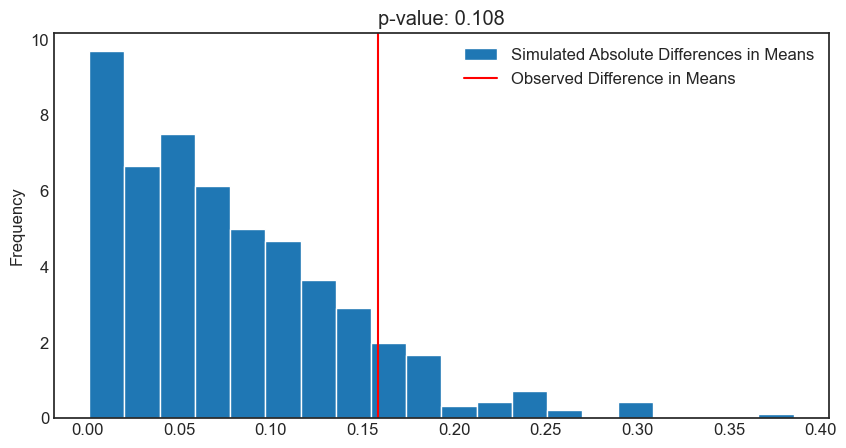

In [7]:
obs_diff = data.groupby('group')['data'].mean().diff().abs().iloc[-1]
pval = np.mean(np.array(diff_means) >= obs_diff)

pd.Series(diff_means).plot(kind='hist', density=True, ec='w', bins=20, title=f'p-value: {pval}', label='Simulated Absolute Differences in Means')
plt.axvline(obs_diff, color='red', label='Observed Difference in Means')
plt.legend();

### Telling quantitative distributions apart

- The difference in means only works as a test statistic in permutation tests **if the two distributions have similar shapes**.
    - It tests to see if one is a shifted version of the other.
- We need a better test statistic to differentiate between quantitative distributions with different shapes.
- In other words, we need a **distance** metric between quantitative distributions.
    - The TVD is a distance metric between categorical distributions.

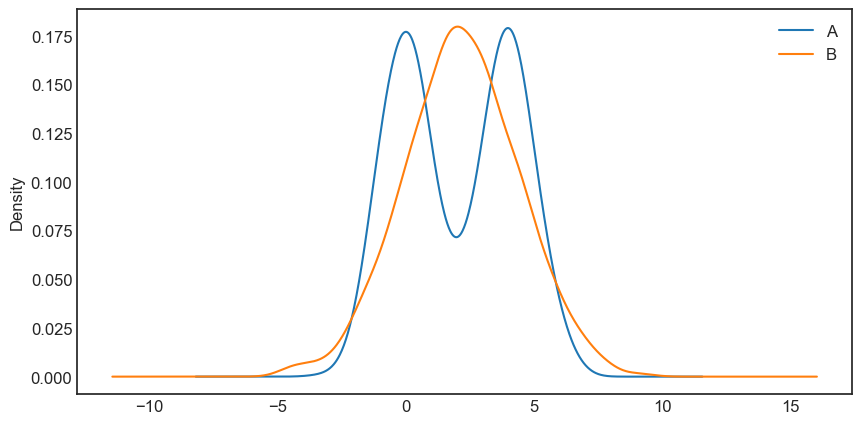

In [8]:
data.groupby('group')['data'].plot(kind='kde', legend=True);

### The Kolmogorov-Smirnov test statistic

- The K-S test statistic measures the similarity between two distributions.
- It is defined in terms of the **cumulative distribution function (CDF)** of a given distribution.
    - If $f(x)$ is a distribution, then the CDF $F(x)$ is the proportion of values in distribution $f$ that are less than or equal to $x$.
- The K-S statistic is roughly defined as the **largest difference between two CDFs**.
<center><img src=./imgs/KS2_Example.png width=50%></center>

### Aside: cumulative distribution functions

Let's look at the CDFs of our two synthetic distributions.

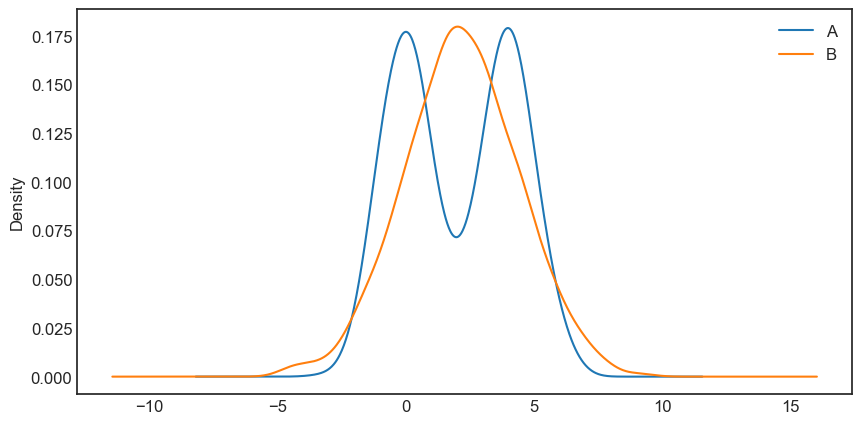

In [9]:
# Original data
data.groupby('group')['data'].plot(kind='kde', legend=True);

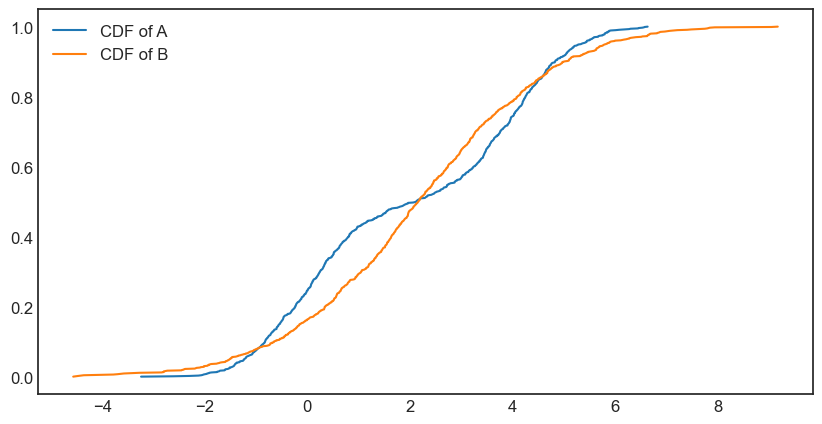

In [10]:
# Try and figure out how this code works!
gpA = data.loc[data['group'] == 'A', 'data']
gpB = data.loc[data['group'] == 'B', 'data']

plt.plot(gpA.value_counts(normalize=True).sort_index().cumsum(), label='CDF of A')
plt.plot(gpB.value_counts(normalize=True).sort_index().cumsum(), label='CDF of B')
plt.legend();

In [11]:
gpA = data.loc[data['group'] == 'A', 'data']
gpA

0      0.496714
1     -0.138264
2      0.647689
3      1.523030
4     -0.234153
         ...   
995    3.718900
996    5.797687
997    4.640843
998    3.428821
999    4.572583
Name: data, Length: 1000, dtype: float64

In [12]:
gpB

1000    5.152418
1001    4.089540
1002    2.152841
1003    0.570873
1004    3.582619
          ...   
1995    4.415344
1996    1.959952
1997    0.044859
1998    1.654233
1999    0.351533
Name: data, Length: 1000, dtype: float64

### The K-S statistic in Python

Fortunately, **we don't need to calculate the K-S statistic ourselves**! Python can do it for us (and you can use this pre-built version in all assignments).

In [13]:
from scipy.stats import ks_2samp

In [14]:
ks_2samp?

In [15]:
obs_ks = ks_2samp(gpA, gpB).statistic
obs_ks

0.14

We don't know if this number is big or small. We need to run a permutation test!

In [16]:
n_repetitions = 500
shuffled = data.copy()

ks_stats = []
for _ in range(n_repetitions):
    
    # Shuffling the data and assigning it back to the DataFrame
    shuffled['data'] = np.random.permutation(shuffled['data'])
    
    # Computing and storing the K-S statistic
    groups = shuffled.groupby('group')['data']
    ks_stat = ks_2samp(groups.get_group('A'), groups.get_group('B')).statistic
    ks_stats.append(ks_stat)
    
ks_stats[:10]

[0.037, 0.048, 0.04, 0.068, 0.045, 0.04, 0.042, 0.052, 0.019, 0.029]

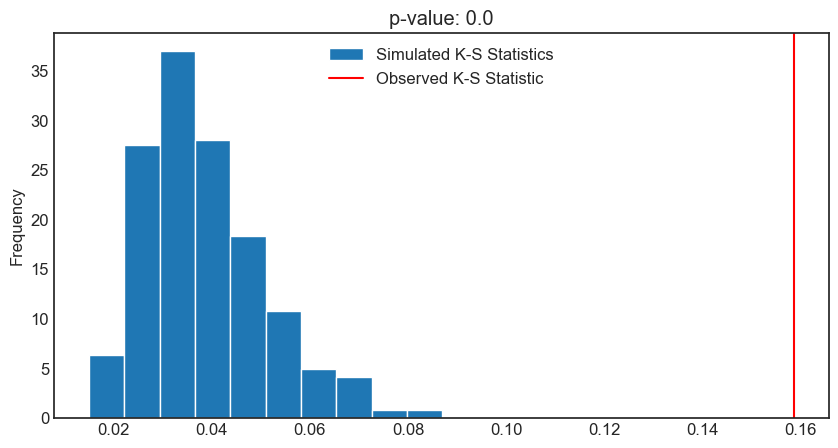

In [17]:
pval = np.mean(np.array(ks_stats) >= obs_ks)

pd.Series(ks_stats).plot(kind='hist', density=True, ec='w', title=f'p-value: {pval}', label='Simulated K-S Statistics')
plt.axvline(obs_diff, color='red', label='Observed K-S Statistic')
plt.legend();

We were able to differentiate between the two distributions using the K-S test statistic!

### `ks_2samp`

* `scipy.stats.ks_2samp` actually returns **both** the statistic **and** a p-value.
* The p-value is calculated using the permutation test we just performed!

In [18]:
ks_2samp(gpA, gpB)

KstestResult(statistic=0.14, pvalue=5.822752148022591e-09)

### Difference in means vs. K-S statistic

- The K-S statistic measures the difference between two distributions.
- It **does not** quantify if one is larger than the other on average, so there are times we still need to use the difference in means.
- Strategy: Always plot the two distributions you are comparing.
    - If the distributions have similar shapes but are centered in different places, use the difference in means (or absolute difference in means).
    - If your alternative hypothesis involves a "direction" (i.e. smoking weights were are on average than non-smoking weights), use the difference in means.
    - If the distributions have different shapes and your alternative hypothesis is simply that the two distributions are different, use the K-S statistic.

## More examples

***Note:*** We are not going to get to these slides in class. They're just here to provide more examples of missingness mechanisms.

### Summary: NMAR 

* Can you make a reasonable case that the differences in missing vs not missing is largely explainable via *observed* data?
    - If yes, then the missing data (column) 'missing at random' and the missing data is 'ignorable' (when handled properly).
    - If no, then the missing data is 'not missing at random' (NMAR), or 'non-ignorable'. You must explicitly model missingness using assumptions on the data generating process.

### Summary: MAR

* If missingness is explainable via *observed* data, then the missing data is 'missing at random' (MAR).
* The distribution of missing data may still look different than the observed data!
    - MAR requires you to understand how the missingness is dependent on other attributes in your data.
* Use permutation tests to assess the dependence of missing data on other attributes.

### Summary: MCAR

* If missingness doesn't depend on any values in the observed data, it is 'unconditionally ignorable' (MCAR).
* MCAR is equivalent to data being MAR, without dependence on any other columns.
* If permutation tests point toward similar distributions of missing vs not-missing data, for *every* other column, then the data *may* be MCAR.
    - Caution: you can't assert the data *are* MCAR, as permutation tests don't allow you to accept the null hypothesis!

### Example: Cars

* We have data on cars that were given tickets.
* For each car, we have their `'vin'` number, `'car_make'`, `'car_year'`, and `'car_color'`.
* **Question:** Is `'car_color'` missing at random, **dependent on `'car_year'`**?
    * Is the distribution of `'car_year'` similar when color is missing vs. not missing?
    * How similar is similar enough?
    
Let's use a permutation test!

In [19]:
cars = pd.read_csv('data/cars.csv')
cars.head()

,vin,car_make,car_year,car_color
0,3D7TT2CT8BG121773,Audi,2008.0,Teal
1,SCBZB25E62C073475,Audi,1996.0,Mauv
2,1FT7W2A69EE682086,NaN,NaN,Turquoise
3,1B3AZ6JZ7AV582128,Ford,2010.0,Goldenrod
4,1GYUCGEF4AR632425,Mazda,1996.0,Purple


In [20]:
# Proportion of car colors missing
cars['car_color'].isna().mean()

0.1542

In [21]:
cars['color_missing'] = cars['car_color'].isna()

In [22]:
cars.head()

,vin,car_make,car_year,car_color,color_missing
0,3D7TT2CT8BG121773,Audi,2008.0,Teal,False
1,SCBZB25E62C073475,Audi,1996.0,Mauv,False
2,1FT7W2A69EE682086,NaN,NaN,Turquoise,False
3,1B3AZ6JZ7AV582128,Ford,2010.0,Goldenrod,False
4,1GYUCGEF4AR632425,Mazda,1996.0,Purple,False


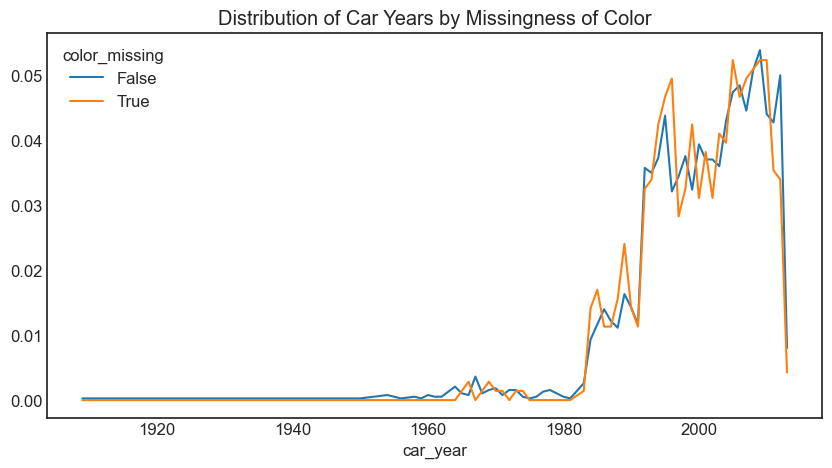

In [23]:
(
    cars
    .pivot_table(index='car_year', columns='color_missing', values=None, aggfunc='size')
    .fillna(0)
    .apply(lambda x: x / x.sum())
    .plot(title='Distribution of Car Years by Missingness of Color')
);

- These distributions look pretty similar. We won't run the permutation test here, but if we did, we'd fail to reject the null. It doesn't seem like the missingness of `'car_color'` depends on `'car_year'`.
- To figure out if the missingness of `'car_color'` is MCAR, we'd need to do a similar analysis for all other columns.

### Missingness of `'car_color'` on `'car_make'`

Let's test whether the missingness of `'car_color'` is dependent on `'car_make'`.

In [24]:
cars.head()

,vin,car_make,car_year,car_color,color_missing
0,3D7TT2CT8BG121773,Audi,2008.0,Teal,False
1,SCBZB25E62C073475,Audi,1996.0,Mauv,False
2,1FT7W2A69EE682086,NaN,NaN,Turquoise,False
3,1B3AZ6JZ7AV582128,Ford,2010.0,Goldenrod,False
4,1GYUCGEF4AR632425,Mazda,1996.0,Purple,False


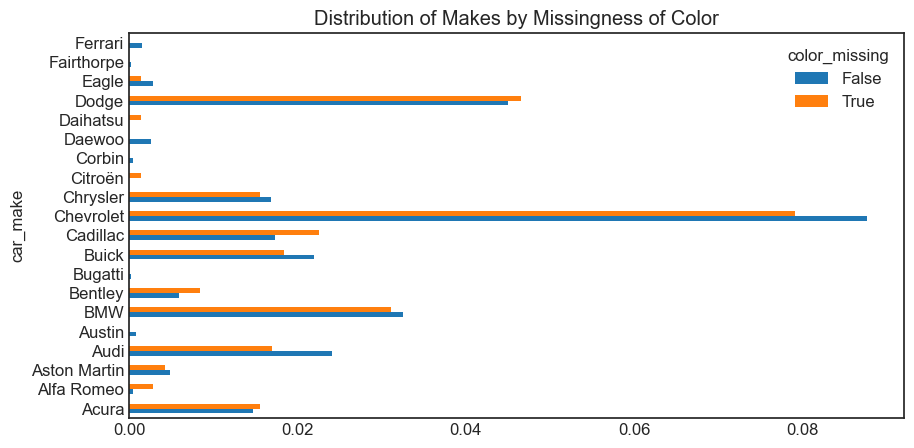

In [25]:
emp_distributions = (
    cars
    .pivot_table(index='car_make', columns='color_missing', values=None, aggfunc='size')
    .fillna(0)
    .apply(lambda x: x / x.sum())
)

# There are too many makes to plot thema ll at once!
emp_distributions.iloc[:20].plot(kind='barh', title='Distribution of Makes by Missingness of Color');

In [26]:
observed_tvd = emp_distributions.diff(axis=1).iloc[:, -1].abs().sum() / 2
observed_tvd

0.10371381974098398

In [27]:
shuffled = cars.copy()[['car_make', 'color_missing']]

n_repetitions = 500
tvds = []

for _ in range(n_repetitions):
    
    # Shuffling the colors and assigning them to the DataFrame
    shuffled['car_make'] = np.random.permutation(shuffled['car_make'])
    
    # Computing and storing the TVD
    pivoted = (
        shuffled
        .pivot_table(index='car_make', columns='color_missing', values=None, aggfunc='size')
        .fillna(0)
        .apply(lambda x: x / x.sum())
    )
    
    tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds.append(tvd)

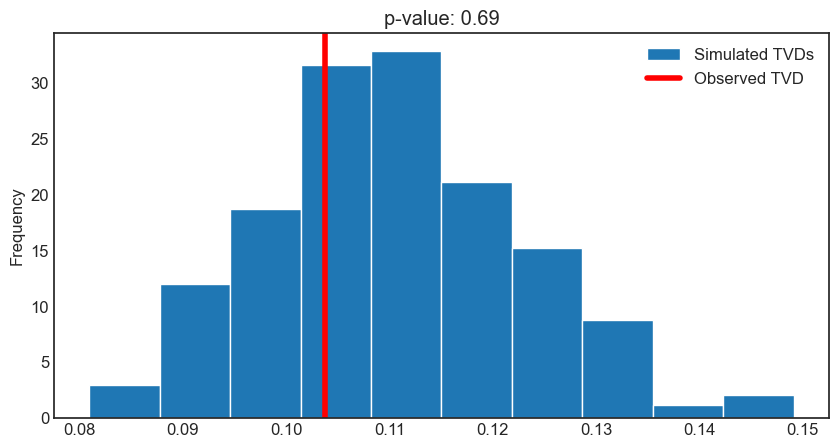

In [28]:
pval = np.mean(tvds >= observed_tvd)

pd.Series(tvds).plot(kind='hist', density=True, ec='w', bins=10, title=f'p-value: {pval}', label='Simulated TVDs')
plt.axvline(x=observed_tvd, color='red', linewidth=4, label='Observed TVD')
plt.legend();

Here, we fail to reject the null that the distribution of `'car_make'` is the same whether or not `'car_color'` is missing.

### Example: Assessing missingness in payments data

* We have payment information for purchases: credit card type, credit card number, date of birth.
* Is the credit card number missing at random dependent on the type of card?

In [29]:
payments = pd.read_csv('data/payment.csv')
payments['cc_isnull'] = payments['credit_card_number'].isna()

In [30]:
payments.head()

,id,credit_card_type,credit_card_number,date_of_birth,cc_isnull
0,1,diners-club-enroute,2.018706e+14,25-Sep-1982,False
1,2,americanexpress,3.737511e+14,08-Jan-1946,False
2,3,jcb,3.570296e+15,NaN,False
3,4,mastercard,5.318327e+15,NaN,False
4,5,maestro,6.759827e+17,20-Apr-1975,False


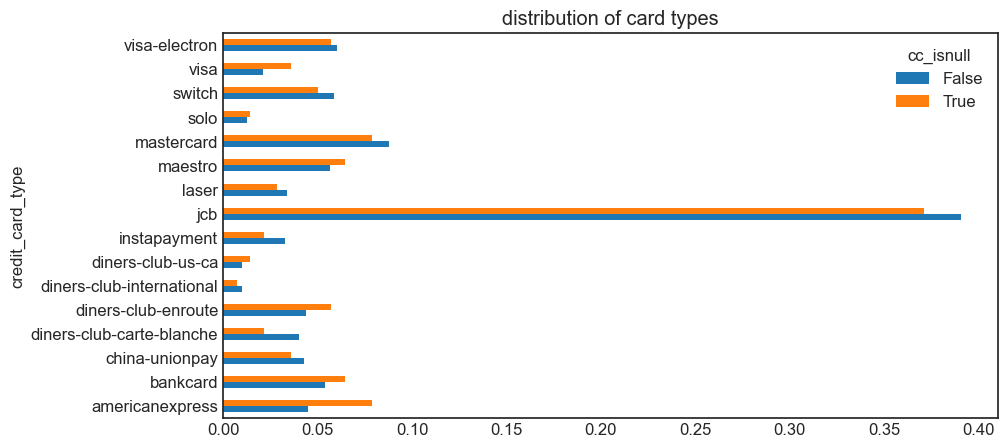

In [31]:
emp_distributions = (
    payments
    .pivot_table(columns='cc_isnull', index='credit_card_type', aggfunc='size')
    .fillna(0)
    .apply(lambda x:x / x.sum())
)

emp_distributions.plot(kind='barh', title='distribution of card types');

In [32]:
observed_tvd = np.sum(np.abs(emp_distributions.diff(axis=1).iloc[:,-1])) / 2
observed_tvd

0.08546365914786964

In [33]:
n_repetitions = 500

payments_type = payments.copy()[['credit_card_type', 'cc_isnull']]
tvds = []
for _ in range(n_repetitions):
    
    shuffled_types = (
        payments_type['credit_card_type']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    shuffled = (
        payments_type
        .assign(**{'Shuffled Types': shuffled_types})
    )
    
    # compute the tvd
    shuffed_emp_distributions = (
        shuffled
        .pivot_table(columns='cc_isnull', index='Shuffled Types', values=None, aggfunc='size')
        .fillna(0)
        .apply(lambda x:x/x.sum())
    )
    
    tvd = np.sum(np.abs(shuffed_emp_distributions.diff(axis=1).iloc[:,-1])) / 2
    # add it to the list of results
    
    tvds.append(tvd)

### Example: assessing missingness in payments data

* Is the credit card number missing at random dependent on the type of card?
* As always, set significance level **beforehand**:
    - How important is the column in the modeling process?
    - How many null values are there?
* Consideration: how important is a faithful imputation?

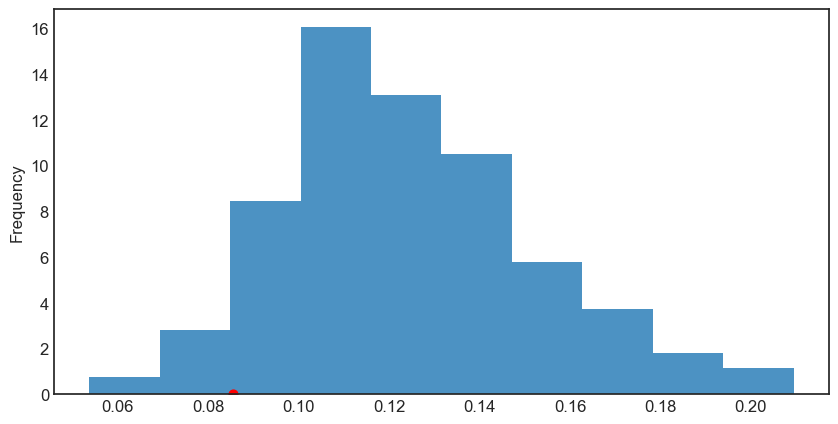

In [34]:
#: visualize
pd.Series(tvds).plot(kind='hist', density=True, alpha=0.8)
plt.scatter(observed_tvd, 0, color='red', s=40);

In [35]:
# p-value
np.count_nonzero(tvds <= observed_tvd) / len(tvds)

0.058

### Example: assessing missingness in payments data

* Is the credit card number missing at random dependent on the age of shopper?
* For quantitative distributions, we've compared means of two groups.

In [36]:
payments['date_of_birth'] = pd.to_datetime(payments.date_of_birth)
payments['age'] = (2019 - payments.date_of_birth.dt.year)

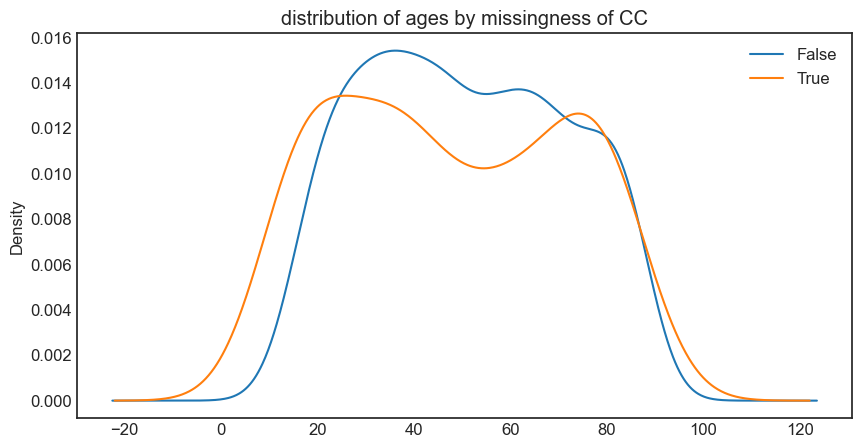

In [37]:
# are the distributions similar?
# Where are the differences? Are they noise, or real?
payments.groupby('cc_isnull').age.plot(kind='kde', title='distribution of ages by missingness of CC', legend=True);

In [39]:
payments.groupby('cc_isnull')['age'].get_group(True)

23     86.0
33     65.0
34      NaN
35     55.0
36     41.0
       ... 
985    40.0
989    40.0
993    18.0
995    32.0
998     NaN
Name: age, Length: 143, dtype: float64

In [41]:
payments

,id,credit_card_type,credit_card_number,date_of_birth,cc_isnull,age
0,1,diners-club-enroute,2.018706e+14,1982-09-25,False,37.0
1,2,americanexpress,3.737511e+14,1946-01-08,False,73.0
2,3,jcb,3.570296e+15,NaT,False,NaN
3,4,mastercard,5.318327e+15,NaT,False,NaN
4,5,maestro,6.759827e+17,1975-04-20,False,44.0
...,...,...,...,...,...,...
995,996,visa-electron,NaN,1987-02-16,True,32.0
996,997,jcb,3.570380e+15,1994-01-12,False,25.0
997,998,mastercard,5.010121e+15,1961-01-22,False,58.0
998,999,visa-electron,NaN,NaT,True,NaN


In [48]:
payments.loc[payments["cc_isnull"],"age"]

23     86.0
33     65.0
34      NaN
35     55.0
36     41.0
       ... 
985    40.0
989    40.0
993    18.0
995    32.0
998     NaN
Name: age, Length: 143, dtype: float64

In [49]:
payments.groupby('cc_isnull')['age'].get_group(True)

23     86.0
33     65.0
34      NaN
35     55.0
36     41.0
       ... 
985    40.0
989    40.0
993    18.0
995    32.0
998     NaN
Name: age, Length: 143, dtype: float64

In [38]:
ks_2samp(
    payments.groupby('cc_isnull')['age'].get_group(True),
    payments.groupby('cc_isnull')['age'].get_group(False)
)

KstestResult(statistic=0.12699202780883062, pvalue=0.0344518152440148)

### Summary

- We can use permutation tests to verify if a column is MAR vs. MCAR.
    - Create two groups: one where values in a column are missing, and another where values in a column aren't missing.
    - To test the missingness of column X:
        - For every other column, test the null hypothesis "the distribution of (other column) is the same when column X is missing and when column X is not missing."
        - If you fail to reject the null, then column X's missingness does not depend on (other column).
        - If you reject the null, then column X is MAR dependent on (other column).
        - **If you fail to reject the null for all other columns, then column X is MCAR!**